Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from pathlib import Path
import glob
from scipy.io import loadmat
import cv2
from scipy.ndimage import gaussian_filter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader as TorchDataLoader
import torchvision

Load Image (Mengambil satu image)

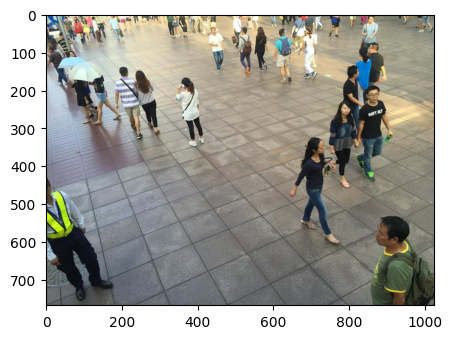

In [ ]:
path_img_ex = r'C:\Users\khair\shanghai\ShanghaiTech\part_B\train_data\images\IMG_6.jpg'
image_ex = cv2.cvtColor(cv2.imread(path_img_ex), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(image_ex)
plt.show()

Ground Truth
(koordinat titik dalam gambar)

In [ ]:
path_gt_ex = r"C:\Users\khair\shanghai\ShanghaiTech\part_B\train_data\ground-truth\GT_IMG_6.mat"
gt_ex = loadmat(path_gt_ex)
print('type: ', type(gt_ex))
print(gt_ex.items())
print(gt_ex.keys())

type:  <class 'dict'>
dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 19:55:34 2016'), ('__version__', '1.0'), ('__globals__', []), ('image_info', array([[array([[(array([[  3.94945534, 469.96427015],
                       [919.86056645, 584.69019608],
                       [722.64575163, 353.34204793],
                       [794.70501089, 254.73464052],
                       [866.76427015, 219.65315904],
                       [815.56427015, 156.12723312],
                       [371.83093682, 180.77908497],
                       [251.416122  , 168.45315904],
                       [204.95686275, 154.23093682],
                       [ 12.48278867,  92.36427015],
                       [ 20.54204793,  71.50501089],
                       [ 70.31982571, 107.53464052],
                       [ 43.53464052,  59.06056645],
                       [ 84.18649237,  18.26056645],
                       [100.83834423,  16.18649237],
             

In [ ]:
gt_coor_ex = gt_ex.get('image_info')[0][0][0][0][0]
print('Shape of coordinates: ', gt_coor_ex.shape)

Shape of coordinates:  (36, 2)


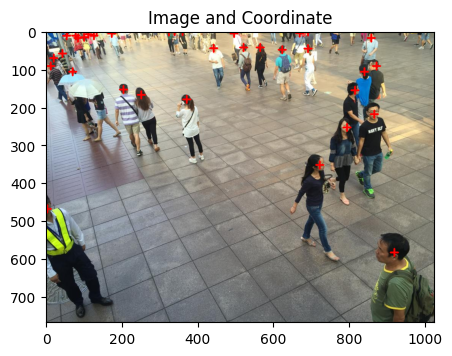

In [ ]:
plt.figure(figsize=(5,5))
for x_cor, y_cor in gt_coor_ex:
    cv2.drawMarker(image_ex, (int(x_cor), int(y_cor)), (255, 0, 0), thickness=3)
plt.imshow(image_ex)
plt.title("Image and Coordinate")
plt.show()

Density Map

In [ ]:
def gen_density_map_gaussian(image, coords, sigma=5):
    img_zeros = np.zeros(image.shape[:2], dtype=np.float32)
    for x, y in coords:
        img_zeros[int(y), int(x)] = 1
    density_map = gaussian_filter(img_zeros, sigma=sigma, truncate=5)
    return density_map

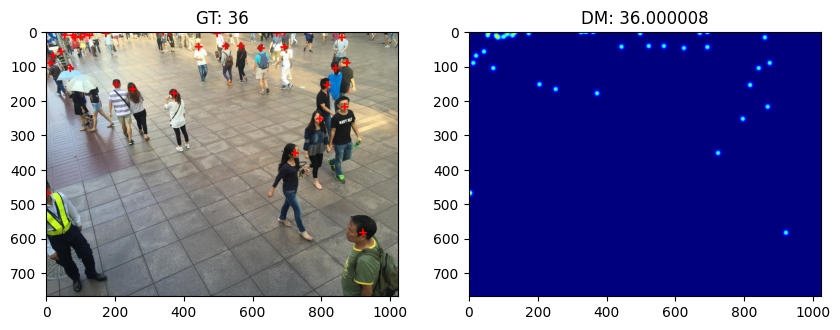

In [ ]:
density_map_ex = gen_density_map_gaussian(image_ex, gt_coor_ex, 5)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(torch.tensor(image_ex/255, dtype=torch.float))
plt.title('GT: ' + str(gt_coor_ex.shape[0]))
plt.subplot(1,2,2)
plt.imshow(density_map_ex, cmap="jet")
plt.title('DM: ' + str(np.sum(density_map_ex)))
plt.show()

In [ ]:
print('max1 : ', image_ex.max())
print('max2 : ', density_map_ex.max())
print('min1 : ', image_ex.min())
print('min2 : ', density_map_ex.min())

max1 :  255
max2 :  0.012646901
min1 :  0
min2 :  0.0


Data Loader Function

In [ ]:
class DataLoader(Dataset):
    def __init__(self, root_dir, gt_downsample=4, shuffle=False):
        self.root_dir = root_dir
        self.gt_downsample = gt_downsample
        self.shuffle = shuffle
        self.img_names = [filename for filename in os.listdir(os.path.join(root_dir, 'images')) if filename.endswith('.jpg')]
        if self.shuffle:
            random.shuffle(self.img_names)
        self.n_people = {}
        self.DMs = {}
        for image_filename in self.img_names:
            img_path = os.path.join(root_dir, 'images', image_filename)
            GT_filename = 'GT_' + image_filename.split('.')[0] + '.mat'
            path_GT = os.path.join(root_dir, 'ground-truth', GT_filename)
            GT = loadmat(path_GT).get('image_info')[0][0][0][0][0]
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            self.DMs[img_path] = gen_density_map_gaussian(img, GT, 5)
            self.n_people[img_path] = GT.shape[0]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, 'images', self.img_names[index])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        gt_density_map = self.DMs[img_path]
        gt_n_people = self.n_people[img_path]
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]
            img = np.concatenate((img, img, img), 2)
        ds_rows = int(img.shape[0] // self.gt_downsample)
        ds_cols = int(img.shape[1] // self.gt_downsample)
        img = cv2.resize(img, (ds_cols*self.gt_downsample, ds_rows*self.gt_downsample))
        gt_density_map = cv2.resize(gt_density_map, (ds_cols, ds_rows))
        gt_density_map = gt_density_map[np.newaxis, :, :] * self.gt_downsample * self.gt_downsample
        img = img.transpose((2,0,1))
        img_tensor = torch.tensor(img/255, dtype=torch.float)
        dm_tensor = torch.tensor(gt_density_map, dtype=torch.float)
        return img_tensor, dm_tensor, gt_n_people

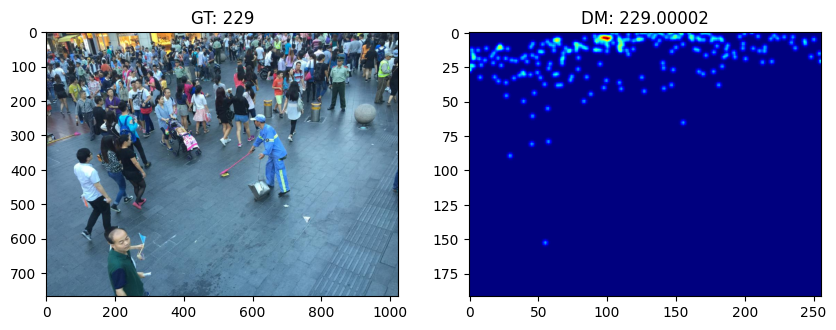

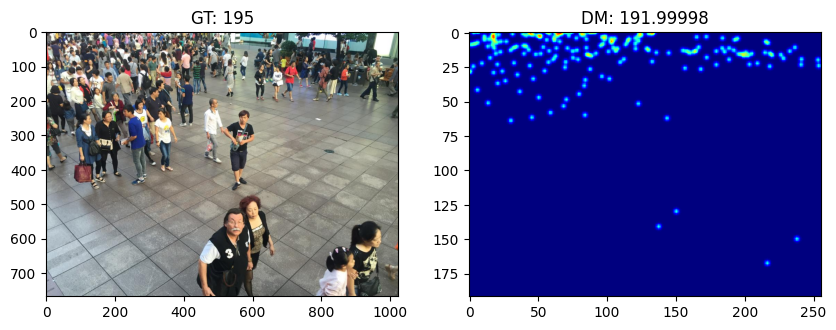

In [ ]:
root_dir = r"C:\Users\khair\shanghai\ShanghaiTech\part_B\test_data"
dataset = DataLoader(root_dir, gt_downsample=4, shuffle=True)
for i, (img, gt_dmap, n_people) in enumerate(dataset):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title('GT: ' + str(n_people))
    plt.subplot(1,2,2)
    plt.imshow(gt_dmap.permute(1, 2, 0), cmap="jet")
    plt.title('DM: ' + str(np.sum(gt_dmap.numpy())))
    plt.show()
    if i > 0:
        break

MCNN Model

In [ ]:
class MC_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.column1 = nn.Sequential(
            nn.Conv2d(3, 8, 9, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 7, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 7, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 16, 7, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 8, 7, padding='same'),
            nn.ReLU(),
        )
        self.column2 = nn.Sequential(
            nn.Conv2d(3, 10, 7, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 40, 5, padding='same'),
            nn.ReLU(),
            nn.Conv2d(40, 20, 5, padding='same'),
            nn.ReLU(),
            nn.Conv2d(20, 10, 5, padding='same'),
            nn.ReLU(),
        )
        self.column3 = nn.Sequential(
            nn.Conv2d(3, 12, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(12, 24, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 48, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(48, 24, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(24, 12, 3, padding='same'),
            nn.ReLU(),
        )
        self.fusion_layer = nn.Sequential(
            nn.Conv2d(30, 1, 1, padding=0),
        )
    def forward(self, img_tensor):
        x1 = self.column1(img_tensor)
        x2 = self.column2(img_tensor)
        x3 = self.column3(img_tensor)
        x = torch.cat((x1, x2, x3), 1)
        x = self.fusion_layer(x)
        return x


Data Loader Preparation (for training & testing)

In [ ]:
img = torch.rand((1, 3, 768, 1024), dtype=torch.float)
mcnn = MC_CNN()
out_dmap = mcnn(img)
print(out_dmap.shape)

torch.Size([1, 1, 192, 256])


In [ ]:
from torch.utils.data import DataLoader as TorchDataLoader  # Corrected import statement

batch_size = 8
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_root_dir = r"C:\Users\khair\shanghai\ShanghaiTech\part_B\train_data"
init_training_set = DataLoader(train_root_dir, gt_downsample=4, shuffle=True)

# Data Splitting
train_size = int(0.9 * len(init_training_set))
val_size = len(init_training_set) - train_size

train_indices = list(range(train_size))
val_indices = list(range(train_size, len(init_training_set)))
train_dataset = torch.utils.data.dataset.Subset(init_training_set, train_indices)
val_dataset = torch.utils.data.dataset.Subset(init_training_set, val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Corrected usage
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Corrected usage

test_root_dir = r"C:\Users\khair\shanghai\ShanghaiTech\part_B\test_data"
test_set = DataLoader(test_root_dir, gt_downsample=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)  # Corrected usage
print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in val_loader:", len(val_loader))
print("Number of batches in test_loader:", len(test_loader))


Number of batches in train_loader: 45
Number of batches in val_loader: 5
Number of batches in test_loader: 40


Plot Pairs (Data Loader)

In [ ]:
def plot_corresponding_pairs(batch1, batch2, plot_map='jet'):
    num_images = batch1.shape[0]
    fig, axes = plt.subplots(int(np.ceil(num_images/2)), 4)
    for i in range(num_images):
        axes[int(i/4)*2, i%4].imshow(batch1[i].permute(1, 2, 0))
        axes[int(i/4)*2, i%4].axis('off')
        axes[int(i/4)*2+1, i%4].imshow(batch2[i].squeeze().detach().numpy(), cmap=plot_map)
        axes[int(i/4)*2+1, i%4].axis('off')
        axes[int(i/4)*2+1, i%4].set_title('DM: ' + str(np.sum(batch2[i].detach().numpy())))
    plt.tight_layout()
    plt.show()

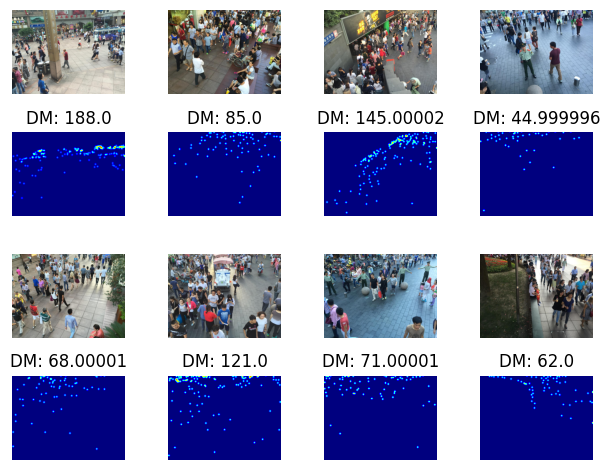

  188    85   145    45    68   121    71    62


In [ ]:
dataiter = iter(train_loader)
ex_images, ex_dmaps, ex_n_people = next(dataiter)
plot_corresponding_pairs(ex_images, ex_dmaps)
print(' '.join('%5s' % ex_n_people[j].item() for j in range(batch_size)))

Training Model

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, weight_dmap=0.8, weight_sum_gt=0.2):
        super().__init__()
        self.weight_dmap = weight_dmap
        self.weight_sum_gt = weight_sum_gt
        self.img_loss = nn.MSELoss()
        self.gt_loss_mse = nn.MSELoss()
        self.gt_loss_mae = nn.L1Loss()

    def forward(self, logits, batch_dmap, batch_gts):
        batch_gts = batch_gts.float()
        img_loss = self.img_loss(logits, batch_dmap)
        gt_loss_mae = self.gt_loss_mae(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)
        gt_loss_mse = self.gt_loss_mse(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)
        combined_loss = self.weight_dmap * img_loss + self.weight_sum_gt * gt_loss_mae
        return combined_loss, gt_loss_mae

In [ ]:
num_epochs = 15
train_losses = []
val_losses = []
train_mae_losses = []
val_mae_losses = []
model = MC_CNN().to(device)
criterion = CombinedLoss(0.8, 0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = np.inf
best_nr_epoch = 0
for epoch in range(num_epochs):
    print("Epoch {}:".format(epoch))
    tr_loss_acc = 0.0
    tr_loss_mae_acc = 0.0
    for batch_img, batch_dmap, batch_gts in train_loader:
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)
        logits = model(batch_img)
        loss, mae_loss = criterion(logits, batch_dmap, batch_gts)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss_acc += loss.item()
        tr_loss_mae_acc += mae_loss.item()
    tr_loss = tr_loss_acc / len(train_loader.dataset)
    tr_mae = tr_loss_mae_acc / len(train_loader.dataset)
    print('>> TRAIN: Epoch {} | tr_loss:  {:.6f}'.format(epoch, tr_loss))
    print('>> TRAIN: Epoch {} | mae:      {:.6f}'.format(epoch, tr_mae))
    with torch.inference_mode():
        val_loss_acc = 0.0
        val_loss_mae_acc = 0.0
        for batch_img_val, batch_dmap_val, batch_gts_val in val_loader:
            batch_img_val, batch_dmap_val, batch_gts_val = batch_img_val.to(device), batch_dmap_val.to(device), batch_gts_val.to(device)
            logits = model(batch_img_val)
            loss, mae_loss = criterion(logits, batch_dmap_val, batch_gts_val)
            val_loss_acc += loss.item()
            val_loss_mae_acc += mae_loss.item()
    val_loss = val_loss_acc / len(val_loader.dataset)
    val_mae = val_loss_mae_acc / len(val_loader.dataset)
    print('>> VAL:   Epoch {} | val_loss: {:.6f}'.format(epoch, val_loss))
    print('>> VAL:   Epoch {} | mae:      {:.6f}'.format(epoch, val_mae))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_nr_epoch = epoch
        torch.save(model.state_dict(), './crowd_counting.pth')
    train_losses.append(tr_loss)
    train_mae_losses.append(tr_mae)
    val_losses.append(val_loss)
    val_mae_losses.append(val_mae)
print('best training MAE: ', train_mae_losses[best_nr_epoch])
print('best val MAE:      ', val_mae_losses[best_nr_epoch])

Epoch 0:
>> TRAIN: Epoch 0 | tr_loss:  9.567549
>> TRAIN: Epoch 0 | mae:      47.837494
>> VAL:   Epoch 0 | val_loss: 4.373718
>> VAL:   Epoch 0 | mae:      21.868471
Epoch 1:
>> TRAIN: Epoch 1 | tr_loss:  2.475207
>> TRAIN: Epoch 1 | mae:      12.375922
>> VAL:   Epoch 1 | val_loss: 2.126468
>> VAL:   Epoch 1 | mae:      10.632233
Epoch 2:
>> TRAIN: Epoch 2 | tr_loss:  2.327982
>> TRAIN: Epoch 2 | mae:      11.639800
>> VAL:   Epoch 2 | val_loss: 3.213634
>> VAL:   Epoch 2 | mae:      16.068064
Epoch 3:
>> TRAIN: Epoch 3 | tr_loss:  2.182483
>> TRAIN: Epoch 3 | mae:      10.912306
>> VAL:   Epoch 3 | val_loss: 2.030954
>> VAL:   Epoch 3 | mae:      10.154667
Epoch 4:
>> TRAIN: Epoch 4 | tr_loss:  2.062135
>> TRAIN: Epoch 4 | mae:      10.310568
>> VAL:   Epoch 4 | val_loss: 1.857696
>> VAL:   Epoch 4 | mae:      9.288380
Epoch 5:
>> TRAIN: Epoch 5 | tr_loss:  2.186843
>> TRAIN: Epoch 5 | mae:      10.934108
>> VAL:   Epoch 5 | val_loss: 1.780440
>> VAL:   Epoch 5 | mae:      8.902100


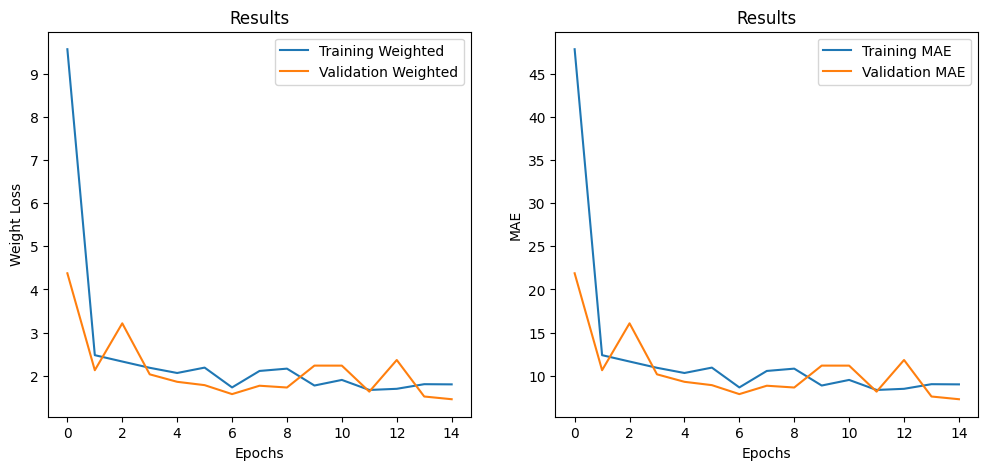

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Weighted')
plt.plot(val_losses, label='Validation Weighted')
plt.title('Results')
plt.ylabel('Weight Loss')
plt.xlabel('Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_mae_losses, label='Training MAE')
plt.plot(val_mae_losses, label='Validation MAE')
plt.title('Results')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

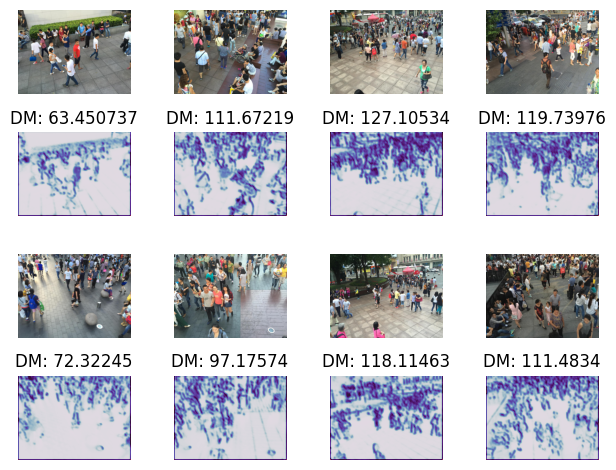

   23    61   252   118    78    36   111   167


In [ ]:
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))
dataiter = iter(val_loader)
ex_images, _, ex_gts  = next(dataiter)
pred_dms = best_model(ex_images.to(device))
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))


In [ ]:
criterion = nn.L1Loss()
test_loss_acc = 0.0
with torch.inference_mode():
    for batch_img, batch_dmap, batch_gts in test_loader:
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)
        logits = best_model(batch_img)
        loss = criterion(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)
        test_loss_acc += loss.item()
print('TEST:  test_MAE: {:.3f}'.format(test_loss_acc / len(test_loader.dataset)))


TEST:  test_MAE: 7.633


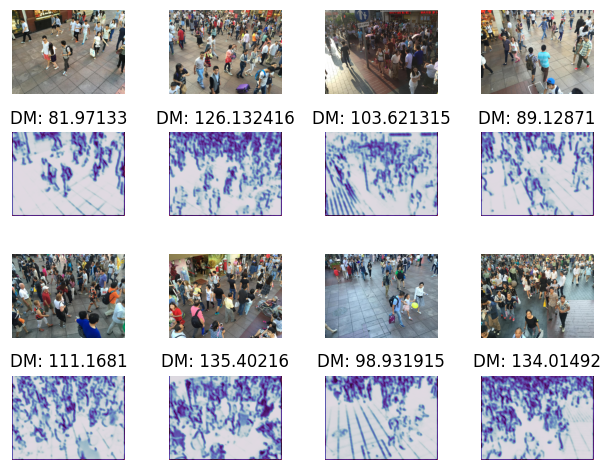

   23   181   157    37    70    57    44   227


In [ ]:
dataiter = iter(test_loader)
ex_images, _, ex_gts  = next(dataiter)
pred_dms = best_model(ex_images.to(device))
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))

Result :
1. Kedua grafik menunjukkan bahwa model mengalami konvergensi setelah beberapa epoch awal. Ini ditandai dengan penurunan signifikan pada loss dan MAE di awal pelatihan, diikuti oleh stabilisasi pada nilai yang lebih rendah.

2. Tidak ada tanda overfitting yang signifikan. Validation loss dan MAE menunjukkan fluktuasi yang serupa dengan training loss dan MAE, yang menunjukkan bahwa model tidak overfitting pada data pelatihan.

3. Penurunan signifikan pada training dan validation loss serta MAE menunjukkan bahwa model belajar dengan baik dari data pelatihan dan mampu membuat prediksi yang akurat pada data validasi.
Stabilitas loss dan MAE setelah beberapa epoch menunjukkan bahwa model telah mencapai titik di mana tambahan pelatihan mungkin tidak akan memberikan peningkatan performa yang signifikan.